## ６章　ゲート付きRNN 

### 6.1 RNNの問題点

5章で作成したRNNは、時系列データの長期の依存関係を学習することが苦手です。

その理由として、BPTT(backpropagation through time)において勾配消失、勾配爆発が起こることが原因があります。

具体的に、次の文章を考えてみたいと思います。

![](../pictures/pict6-1.png)

答えは「Tom」です。RNNLMが正しく答えるには、

「Tomが部屋でテレビを見ていること」
「その部屋にMaryが入ってきたこと」

を記憶しておく必要があります。

つまり、その情報をRNNレイヤの隠れ状態にエンコードして保持しておく必要があります。

「Tom」を正解ラベルとして、勾配はどのように伝播するのか見てみます。

![](../pictures/pict6-2.png)

このシンプルなRNNレイヤでは、時間を遡るの従って勾配が小さくなるか、大きくなるのどちらかになってしまうのがほとんど。

### 6.2 勾配消失もしくは勾配爆発の原因

時間方向だけの勾配の伝播だけに着目してみます。

![](../pictures/pict6-3.png)

ここでは、長さTの時系列データを考え、T番目の正解ラベルから伝わる勾配がどのように変化するかに注視します。

通過する演算は、「tanh」「MatmMul」「+」の３つです。それぞれ見ていきます。

>「+」演算子

上流からの勾配をそのまま流すだけなので、値は変化しません。

>「tanh」演算子

tanhの定義は
$$
f(x) = \text{tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$
これを微分すると
$$
f'(x) = 1 - {f(x)}^{2}
$$
となります。

![](../pictures/pict6-4.png)

この図からもわかるように、微分係数の最大が１で、逆伝播において勾配がtanhを通るたびに、値が小さくなってしまいます。

tanhをT回通過すれば、勾配はT回も弱められることになります。

>「MatMul」演算子

![](../pictures/pict6-5.png)

MatMulレイヤのみに注目して、逆伝播を見てみましょう。

MatMulレイヤを通るたびに、Whが使われています。つまり、同じ重みが使われています。

では、勾配の値はどのように変化するのでしょうか。

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


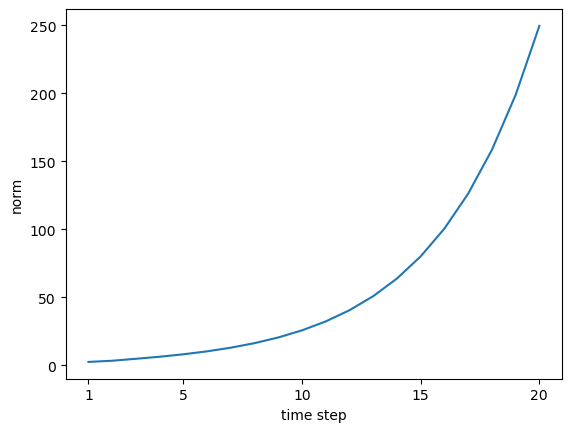

In [1]:
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T): # 20回繰り返す
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


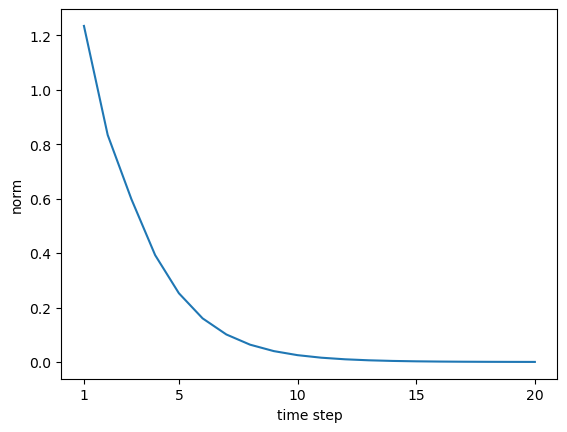

In [2]:
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

#Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T): # 20回繰り返す
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配の大きさは指数的に増加、減少しました。理由はWhをT回乗算しているからです。

Whの特異値の最大値が１より大きいかどうかで、勾配の大きさの変化を予測できます。

### 6.3　勾配爆発への対策


**勾配クリッピング**

$$
\text{if} \quad ||\hat{g}|| \geq \text{threshold} :
$$

$$
\hat{g} = \frac{\text{threshold}}{||\hat{g}||} \hat{g}
$$



ここでｇハットはNNで使われる全てのパラメータに対する勾配を一つにまとめていることを想定しています。

In [3]:
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:  
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


### 6.4 勾配消失とLSTM

勾配消失を解消するには根本的にアーキテクチャを変えなければいけません。

そこで登場するのが、LSTM（Long Short Term Memory）です。

![](../pictures/pict6-6.png)

RNNレイヤとの違いは、ｃという経路があることです。

このｃは***記憶セル***と呼ばれ、LSTM専用の記憶部に相当します。

特徴としては、LSTMレイヤ内だけで情報を受け渡しをします。

つまり、**LSTM内だけで完結し、他のレイヤへは出力しません**

LSTMレイヤの中身を見ていきます。

![](../pictures/pict6-7.png)

この構造を元に、以降様々なゲートを加えていき、LSTMを完成させます。

※ゲートとは

![](../pictures/pict6-8.png)

どれだけゲートを開けるか、もデータから自動的に学ばせます。開き具合を求めるにあたっては、sigmoid関数を使用します。

### 6.5 outputゲート

tanh(Ct)に対してゲートを適用します。つまり、tanh(Ct)の各要素に対して、

「それらが次時刻の隠れ状態としてどれだけ重要か」ということを調整します。

このゲートを次の隠れ状態の出力を司るゲートであることから、**outputゲート**と呼ばれます。行う計算は次のようになります。

$$
\mathbf{o} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(o)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(o)} + \mathbf{b}^{(o)})
$$


![](../pictures/pict6-9.png)

ここでの「o」と「tanh(Ct)」の積はアダマール積（要素ごとの積）になります。

以上がoutputゲートです。

### 6.6 forgetゲート

記憶セルに対して、「何を忘れるか」をゲートで表現します。

C_t-1の記憶から、不要な記憶を忘れるためのゲートを追加します。これをforgetゲートと呼びます。

![](../pictures/pict6-10.png)

行う計算は次の式です。
$$
\mathbf{f} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(f)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(f)} + \mathbf{b}^{(f)})
$$


### 6.7 新しい記憶セル

forgetゲートによって全時刻の記憶セルから忘れられるべきものが削除されました。

しかし、これでは記憶セルは忘れることしかできません。そこで新しく覚えるべき情報を記憶セルに追加します。

![](../pictures/pict6-11.png)

行う計算は次の式です。
$$
\mathbf{g} = \tanh (\mathbf{x}_t \mathbf{W}_x^{(g)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(g)} + \mathbf{b}^{(g)})
$$
tanhノードはゲートではなく、新しい情報を記憶セルに追加することを目的としています。

### 6.8 inputゲート

6.7で考えたｇに対してゲートを加えます。そのゲートをinputゲートと呼びます。


![](../pictures/pict6-12.png)

このゲートは
**ｇの各要素が新たに追加する情報としてどれだけ価値があるのかを判断します。**

$$
\mathbf{i} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(i)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(i)} + \mathbf{b}^{(i)})
$$



### 6.9 LSTMの勾配の流れ

これがなぜ勾配消失を起こさないのでしょうか。

その理由は記憶セルｃの逆伝播にあります。

![](../pictures/pict6-13.png)

記憶セルの逆伝播は、”＋”と”×”ノードだけを通ります。

勾配の変化が起こるのは”×”ノードのみですが、これはforgetゲートによってコントロールされています。

forgetゲートが

>忘れるべきと判断した場合、記憶セルの要素に対しては、その勾配の要素は小さくなります。

>忘れてはいけないと判断した場合、勾配の要素は劣化することなく過去方向へ伝わります。

そのため、記憶セルの勾配は長期にわたって覚えておくべき情報に対しては、勾配消失は起こさずに伝播することが期待できます。

### 6.10 LSTMの実装

LSTMレイヤで行う計算は次の通りです。

$$
\mathbf{f} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(f)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(f)} + \mathbf{b}^{(f)})
$$

$$
\mathbf{g} = \tanh (\mathbf{x}_t \mathbf{W}_x^{(g)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(g)} + \mathbf{b}^{(g)})
$$

$$
\mathbf{i} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(i)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(i)} + \mathbf{b}^{(i)})
$$

$$
\mathbf{o} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(o)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(o)} + \mathbf{b}^{(o)})
$$

$$
\mathbf{c}_t = \mathbf{f} \odot \mathbf{c}_{t-1} + \mathbf{g} \odot \mathbf{i}
$$

$$
\mathbf{h}_t = \mathbf{o} \odot \tanh(\mathbf{c}_t)
$$


これらの式はまとめて計算することが可能です。

![](../pictures/pict6-14.png)

W_x,W_h,bにそれぞれ４つ分の重みが含まれているとして、LSTMの計算グラフは次のようになります。

![](../pictures/pict6-15.png)
コレを参考にLSTMクラスの実装を行います。

In [5]:
import sys
sys.path.append('..')

class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### 6.11 TimeLSTMの実装

![](../pictures/pict6-16.png)

前章で述べたように、RNNで学習を行う際にはTruncated BPTTを行います。（途中で切る）

そのために、隠れ状態と記憶セルをメンバ変数に保持させるようにします。

こうすることで、次のforward()が呼ばれたときに、前時刻の隠れ状態と記憶セルから開始させることが可能になります。

![](../pictures/pict6-17.png)

In [6]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

### 6.12 LSTMを使った言語モデル 

![](../pictures/pict6-18.png)

In [7]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

### 6.13 PTBデータセットの学習

Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.69
| epoch 1 |  iter 21 / 1327 | time 5[s] | perplexity 2965.94
| epoch 1 |  iter 41 / 1327 | time 9[s] | perplexity 1249.75
| epoch 1 |  iter 61 / 1327 | time 14[s] | perplexity 956.98
| epoch 1 |  iter 81 / 1327 | time 19[s] | perplexity 803.35
| epoch 1 |  iter 101 / 1327 | time 23[s] | perplexity 663.06
| epoch 1 |  iter 121 / 1327 | time 28[s] | perplexity 645.11
| epoch 1 |  iter 141 / 1327 | time 33[s] | perplexity 607.36
| epoch 1 |  iter 161 / 1327 | time 38[s] | perplexity 571.35
| epoch 1 |  iter 181 / 1327 | time 42[s] | perplexity 599.47
| epoch 1 |  iter 201 / 1327 | time 47[s] | perplexity 511.06
| epoch 1 |  iter 221 / 1327 | time 51[s] | perplexity 495.86
| epoch 1 |  iter 241 / 1327 | time 56[s] | perplexity 455.63
| epoch 1 |  iter 261 / 1327 | time 60[s] | perplexity 470.05
| epoch 1 |  iter 281 / 1327 | time 65[s] | perplexity 458.06
| epoch 1 |  iter 301 / 1327 | time 69[s] | perplexity 403.31
| epoch 1

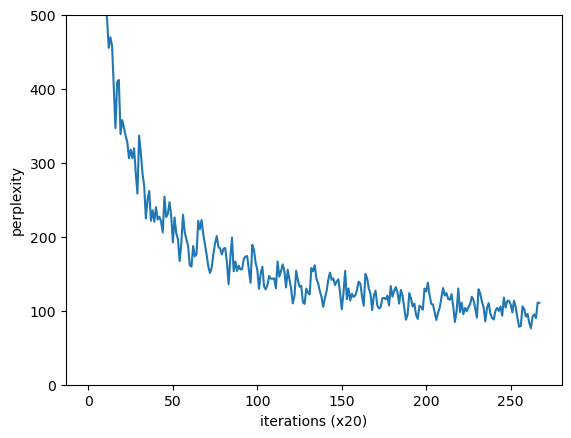

evaluating perplexity ...
234 / 235
test perplexity:  137.4480221788094


In [8]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from datasets import ptb
from rnnlm import Rnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

### 6.14 RNNLMのさらなる改善

#### LSTMレイヤの多層化

#### Dropoutによる過学習の抑制

#### 重み共有